# Figure 1: Kaplan-Meier survival curves for the best-performing gene set.

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter, statistics
from statsmodels.stats.multitest import fdrcorrection

In [4]:
logrank = pd.read_csv("../TCGA/logrank-scores-p-value.tsv", sep="\t", index_col=[0])

# apply FDR over columns
for tcga in logrank.columns:
    logrank[tcga] = fdrcorrection(logrank[tcga].values)[1]

# Shorten index labels
logrank.index = [" ".join(x.split("_")[1:]) for x in logrank.index.values]
logrank.head()

,BLCA,BRCA,CESC,COAD,GBM,HNSC,KIRC,KIRP,LAML,LGG,LIHC,LUAD,LUSC,OV,PRAD,READ,SKCM,STAD,THCA,UCEC
ADIPOGENESIS,0.995510,0.102032,0.711404,0.855305,0.944410,0.005990,0.017909,0.320388,0.164449,0.266482,0.981665,0.505082,0.938437,0.864182,0.984877,0.937849,0.773462,0.911104,0.996257,0.902730
ALLOGRAFT REJECTION,0.994815,0.706447,0.461122,0.970791,0.428182,0.306200,0.235196,0.548572,0.709227,0.005511,0.865158,0.398188,0.590541,0.349749,0.984877,0.876939,0.099430,0.819805,0.996257,0.902730
ANDROGEN RESPONSE,0.989506,0.522130,0.052226,0.943067,0.980487,0.132883,0.000735,0.927312,0.956206,0.144542,0.716222,0.191973,0.719295,0.953557,0.984877,0.928030,0.887859,0.911104,0.996257,0.902730
ANGIOGENESIS,0.989506,0.766739,0.002632,0.970791,0.396422,0.383961,0.331658,0.307505,0.376445,0.000287,0.716222,0.204591,0.454933,0.864182,0.984877,0.968126,0.159158,0.390695,0.996257,0.911739
APICAL JUNCTION,0.989506,0.284112,0.461122,0.970791,0.237282,0.794727,0.828561,0.181088,0.264159,0.018885,0.716222,0.592183,0.401915,0.864182,0.984877,0.928030,0.773462,0.390695,0.996257,0.911739


In [5]:
info = {
    0: ["CESC", "HALLMARK_UV_RESPONSE_DN"],
    1: ["HNSC", "HALLMARK_GLYCOLYSIS"],
    2: ["KIRC", "HALLMARK_HEME_METABOLISM"],
    3: ["LGG", "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION"],
    4: ["LUAD", "HALLMARK_MTORC1_SIGNALING"],
    5: ["SKCM", "HALLMARK_INTERFERON_GAMMA_RESPONSE"],
}

data_storage = {
    tcga: [
        pd.read_csv(f"../TCGA/TCGA-{tcga}-ssGSEA.tsv", sep="\t", index_col=[0]),
        pd.read_csv(f"../TCGA/TCGA-{tcga}-metadata.tsv", sep="\t", index_col=[0]),
    ]
    for tcga, _ in info.values()
}

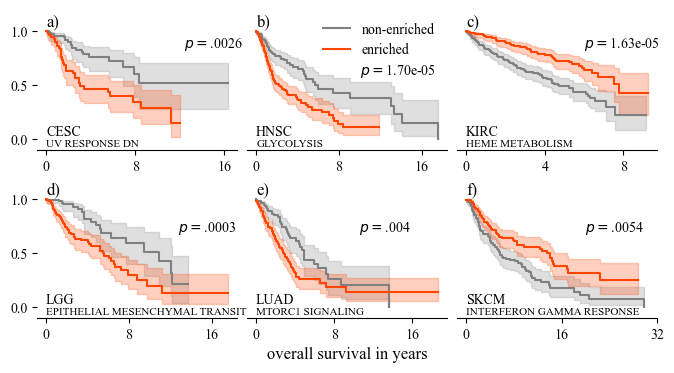

In [6]:
try:
    plt.rcParams["font.family"] = "Times New Roman"
except Exception as e:
    print(e)
    print("Unable to load 'Times New Roman' font. Continuing with default.")

f, ax = plt.subplots(2, 3, figsize=(8, 4), gridspec_kw={"wspace": 0.05})

FOUR_YEARS = 4 * 365
RIGHT_XTICK = np.array([4, 4, 2, 4, 4, 8])

AXES_LABELS = list("abcdef")
P_VAL_POSITION = [
    [0.85, 3.1 * FOUR_YEARS],
    [0.6, 2.5 * FOUR_YEARS],
    [0.85, 1.5 * FOUR_YEARS],
    [0.7, 3.2 * FOUR_YEARS],
    [0.7, 2.65 * FOUR_YEARS],
    [0.7, 5 * FOUR_YEARS],
]

for i in range(6):
    x, y = i // 3, i % 3

    # retrieve data
    tcga, geneset = info[i]
    ssgsea, meta = data_storage[tcga]

    group = ssgsea[geneset] > np.median(ssgsea[geneset])
    group_names = ["non-enriched", "enriched"]  # for 0 and 1

    # PLOT KM
    T = meta["time"]
    E = meta["event"]

    kmf = KaplanMeierFitter()
    kmf.fit(T[-group], event_observed=E[-group], label=group_names[0])
    kmf.plot_survival_function(ax=ax[x][y], color="gray")

    kmf.fit(T[group], event_observed=E[group], label=group_names[1])
    kmf.plot_survival_function(ax=ax[x][y], color="orangered")

    p_value = logrank.loc[" ".join(geneset.split("_")[1:]), tcga]

    # add project names
    ax[x][y].text(0, 1.05, f"{AXES_LABELS[i]})", fontsize=12)
    ax[x][y].text(0, 0, tcga, fontsize=10, verticalalignment="bottom")
    ax[x][y].text(
        0, 0, " ".join(geneset.split("_")[1:]), fontsize=8, verticalalignment="top"
    )

    if p_value < 1e-4:
        p_val_lab = f"$p=${p_value:.2e}"
    else:
        p_val_lab = f"$p=${str(round(p_value, 4))[1:]}"
    ax[x][y].text(
        P_VAL_POSITION[i][1],
        P_VAL_POSITION[i][0],
        p_val_lab,
        fontsize=10,
        horizontalalignment="left",
    )

    # adjust plots
    ax[x][y].set_ylim(-0.1, 1.2)

    ax[x][y].spines["top"].set_visible(False)
    ax[x][y].spines["left"].set_visible(False)
    ax[x][y].spines["right"].set_visible(False)

    ax[x][y].set_yticks([0, 0.5, 1])
    ax[x][y].set_xticks(np.array([0, RIGHT_XTICK[i] // 2, RIGHT_XTICK[i]]) * FOUR_YEARS)
    ax[x][y].set_xticklabels(np.array([0, RIGHT_XTICK[i] // 2, RIGHT_XTICK[i]]) * 4)

    if i != 1:
        ax[x][y].get_legend().remove()
    else:
        ax[x][y].legend(fontsize=10, frameon=False, loc=1)

    if i == 4:
        ax[x][y].set_xlabel("overall survival in years", fontsize=12)
    else:
        ax[x][y].set_xlabel(None)

    if i not in [0, 3]:
        ax[x][y].set_yticks([])
        ax[x][y].set_yticklabels([])

f.savefig("../figures/figure1.png", bbox_inches="tight", dpi=500)